In [1]:
import os
import glob
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
user_name = 'sally'  # 윈도우 사용자 이름으로 변경하세요
desktop_path = f'C:\\Users\\{user_name}\\OneDrive\\바탕 화면\\ai_eye'

In [3]:
symptom = 'E08'

# 이미지 경로 설정
train_asym_img_path = os.path.join(desktop_path, f'train_asym_{symptom}')
train_sym_img_path = os.path.join(desktop_path, f'train_sym_{symptom}')
validation_asym_img_path = os.path.join(desktop_path, f'val_asym_{symptom}')
validation_sym_img_path = os.path.join(desktop_path, f'val_sym_{symptom}')

In [4]:
# 이미지 로드 및 라벨 생성 함수
def load_images_and_labels(sym_paths, asym_paths):
    images = []
    labels = []
    extensions = ['*.jpg', '*.jpeg', '*.png']  # 지원할 파일 확장자 목록

    for path in sym_paths:
        for ext in extensions:
            sym_images = glob.glob(os.path.join(path, ext))
            for image_path in sym_images:
                img = np.array(Image.open(image_path).resize((224,224)))
                images.append(img)
                labels.append(1)  # 'sym' 라벨

    for path in asym_paths:
        for ext in extensions:
            asym_images = glob.glob(os.path.join(path, ext))
            for image_path in asym_images:
                img = np.array(Image.open(image_path).resize((224,224)))
                images.append(img)
                labels.append(0)  # 'asym' 라벨

    # 로드된 이미지와 라벨 개수 출력
    print(f"Loaded {len(images)} images and {len(labels)} labels.")
    
    return np.array(images), np.array(labels)

In [5]:
# 훈련 및 검증 데이터 로드
train_images_sym, train_labels_sym = load_images_and_labels([train_sym_img_path], [])
train_images_asym, train_labels_asym = load_images_and_labels([], [train_asym_img_path])
val_images_sym, val_labels_sym = load_images_and_labels([validation_sym_img_path], [])
val_images_asym, val_labels_asym = load_images_and_labels([], [validation_asym_img_path])

Loaded 4810 images and 4810 labels.
Loaded 4800 images and 4800 labels.
Loaded 576 images and 576 labels.
Loaded 600 images and 600 labels.


In [6]:
# sym 파일과 asym 파일 각각 결합
sym_images = np.concatenate([train_images_sym, val_images_sym], axis=0)
sym_labels = np.concatenate([train_labels_sym, val_labels_sym], axis=0)
asym_images = np.concatenate([train_images_asym, val_images_asym], axis=0)
asym_labels = np.concatenate([train_labels_asym, val_labels_asym], axis=0)

In [7]:
# sym과 asym 개수 세기
sym_count = len(sym_labels)
asym_count = len(asym_labels)

# 데이터 개수 출력
print(f"Symptomatic images: {sym_count}")
print(f"Asymptomatic images: {asym_count}")

Symptomatic images: 5386
Asymptomatic images: 5400


In [8]:
# 부족한 클래스에 맞춰 데이터 증강
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

if sym_count < asym_count:
    augmentation_target = sym_images
    augmentation_target_label = 1
    target_count = asym_count
else:
    augmentation_target = asym_images
    augmentation_target_label = 0
    target_count = sym_count

augmented_images = []
augmented_labels = []

for img in augmentation_target:
    img = img.reshape((1,) + img.shape)  # (1, 224, 224, 3) 형태로 변환
    i = 0
    for batch in datagen.flow(img, batch_size=1):
        augmented_images.append(batch[0].astype(np.uint8))  # 메모리 절약을 위해 dtype 변경
        augmented_labels.append(augmentation_target_label)
        i += 1
        if len(augmented_labels) + len(augmentation_target) >= target_count:
            break

In [9]:
# 증강된 데이터와 원본 데이터 결합
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

if augmentation_target_label == 1:
    sym_images = np.concatenate([sym_images, augmented_images], axis=0)
    sym_labels = np.concatenate([sym_labels, augmented_labels], axis=0)
else:
    asym_images = np.concatenate([asym_images, augmented_images], axis=0)
    asym_labels = np.concatenate([asym_labels, augmented_labels], axis=0)

In [10]:
# 결합된 최종 데이터셋
images = np.concatenate([sym_images, asym_images], axis=0)
labels = np.concatenate([sym_labels, asym_labels], axis=0)

In [11]:
# 데이터를 8:2 비율로 train과 test로 나누기
X_train_val, X_test, y_train_val, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

# train_val 데이터를 3:1 비율로 train과 validation으로 나누기 (전체 데이터의 6:2:2 비율)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

In [12]:
def normalize_batch(data, batch_size):
    num_batches = int(np.ceil(len(data) / batch_size))
    for i in range(num_batches):
        start = i * batch_size
        end = min((i + 1) * batch_size, len(data))
        data[start:end] = data[start:end] / 255.0

# 배치 사이즈 설정
batch_size = 1000

# 데이터 정규화
normalize_batch(X_train, batch_size)
normalize_batch(X_val, batch_size)
normalize_batch(X_test, batch_size)

In [13]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),  # conv_1_filter=32, conv_1_kernel=3
    MaxPooling2D((2, 2)),
    Conv2D(64, (5, 5), activation='relu'),  # conv_2_filter=64, conv_2_kernel=5
    MaxPooling2D((2, 2)),
    Conv2D(64, (5, 5), activation='relu'),  # conv_3_filter=64, conv_3_kernel=5
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),  # conv_4_filter=32, conv_4_kernel=3
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),  # dense_units=128
    Dropout(0.3),  # dropout=0.3
    Dense(1, activation='sigmoid')  # 이진 분류를 위해 출력 노드 수를 1로 설정하고, 활성화 함수를 sigmoid로 설정
])

C:\Users\sally\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
# 모델 훈련
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# 테스트 데이터셋을 사용하여 최종 모델 평가
test_score = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_score[1]}')

Epoch 1/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 269s 873ms/step - accuracy: 0.7868 - loss: 0.4214 - val_accuracy: 0.9042 - val_loss: 0.2592
Epoch 2/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 281s 923ms/step - accuracy: 0.9044 - loss: 0.2770 - val_accuracy: 0.9070 - val_loss: 0.2499
Epoch 3/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 286s 942ms/step - accuracy: 0.9180 - loss: 0.2334 - val_accuracy: 0.9113 - val_loss: 0.2331
Epoch 4/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 270s 890ms/step - accuracy: 0.9162 - loss: 0.2240 - val_accuracy: 0.9138 - val_loss: 0.2212
Epoch 5/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 276s 909ms/step - accuracy: 0.9245 - loss: 0.2073 - val_accuracy: 0.9175 - val_loss: 0.2148
Epoch 6/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 287s 942ms/step - accuracy: 0.9250 - loss: 0.2035 - val_accuracy: 0.8993 - val_loss: 0.2471
Epoch 7/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 250s 820ms/step - accuracy: 0.9282 - loss: 0.1959 - val_accuracy: 0.9203 - val_loss: 0.2088
Epoch 8/10
304/304 ━━━━━━━━━━━━━━━━━━━━ 250s 824ms/step - accuracy: 0.9287 -

In [16]:
# 모델 저장
model.save('E10_resnet_model.keras', include_optimizer=True)
print("Model saved as E10_efficientnet_model.keras")

Model saved as E10_efficientnet_model.keras


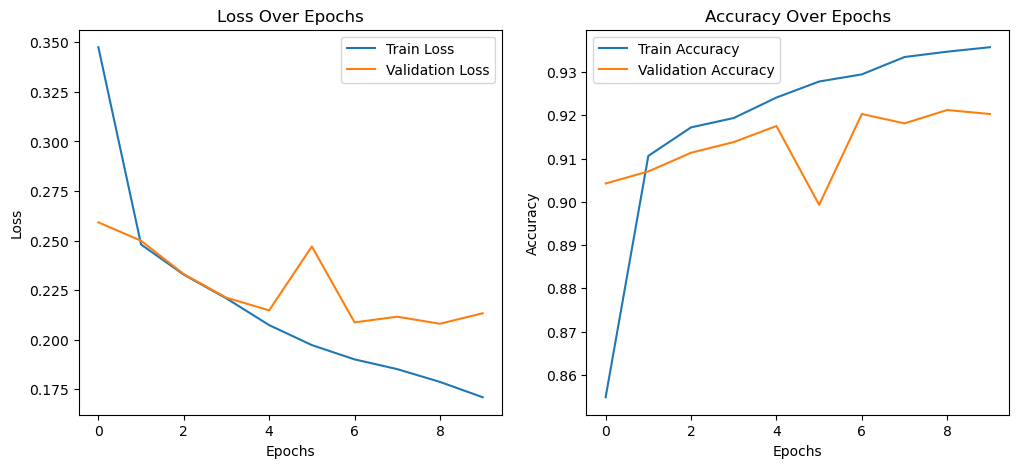

In [17]:
# 훈련 및 검증 손실 플로팅
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 훈련 및 검증 정확도 플로팅
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 그래프를 파일로 저장
plt.savefig('E4_training_validation_loss_accuracy.png')
plt.show()

In [18]:
# 예측값 계산
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

102/102 ━━━━━━━━━━━━━━━━━━━━ 24s 233ms/step


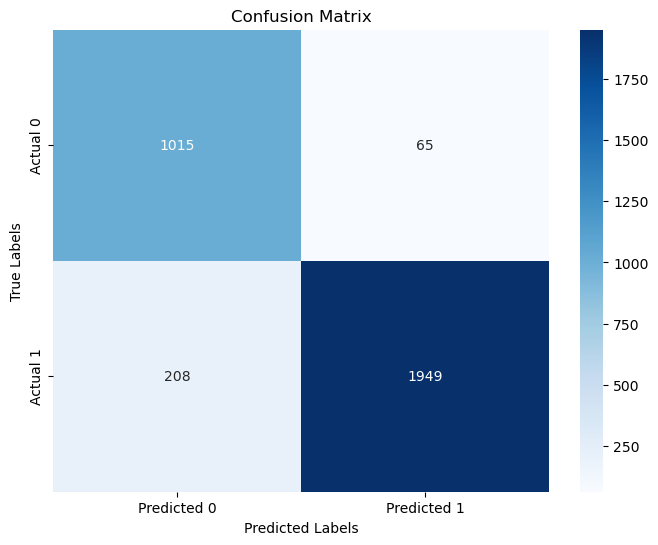

In [19]:
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# 그래프를 파일로 저장
plt.savefig('E4_confusion_matrix.png')
plt.show()

In [20]:
# 개별 지표 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.9156626506024096
Precision: 0.9677259185700099
Recall: 0.903569772832638
F1 Score: 0.9345480700071924


In [21]:
# ROC Curve 및 AUC 계산
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)

print(f'AUC Score: {auc}')

AUC Score: 0.9696268823297103
